In [2]:
library(Matrix)
library("data.table")
library(edgeR)
library(SingleCellExperiment)
library(scran)
library(scuttle)


In [3]:
# Load male read count data
load(file="data/stevant/male_count.Robj")

In [4]:
# Check counst table
male_count[1:10,1:10]
dim(male_count)

,E10.5_XY_20140428_C01_140729_1,E10.5_XY_20140428_C02_140729_1,E10.5_XY_20140428_C03_140729_1,E10.5_XY_20140428_C04_140729_2,E10.5_XY_20140428_C05_140729_2,E10.5_XY_20140428_C07_140729_3,E10.5_XY_20140428_C09_140729_3,E10.5_XY_20140428_C10_140729_4,E10.5_XY_20140428_C11_140729_4,E10.5_XY_20140428_C12_140729_4
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
eGFP,6,41270,2994,12,274,64,2746,1462,578,24964
Gnai3,1218,3552,3782,2732,6276,17860,2750,2,392,7198
Pbsn,0,0,0,0,0,0,0,0,0,0
Cdc45,302,30,8,3478,328,2,0,0,0,0
H19,21740,20900,15154,25880,6934,7044,13894,30486,54290,28190
Scml2,0,2,160,0,0,0,0,0,0,0
Apoh,0,0,0,0,0,0,0,0,0,0
Narf,64,1422,16,0,770,4,256,2048,100,4936
Cav2,0,0,0,0,0,0,0,0,0,0


[1] 43310   401

We have 43310 genes and 401 cells

In [5]:
prot_coding_genes <- read.csv(file="data/stevant/prot_coding.csv", row.names=1)
head(prot_coding_genes) #Note genes are named by symbol
dim(prot_coding_genes)

,x
,<chr>
1,Xkr4
2,Rp1
3,Sox17
4,Mrpl15
5,Lypla1
6,RP24-426M1.3


[1] 22033     1

We have 22033 protein coding genes. 

In [6]:
#We first filter the single cell data  the protein coding genes 

counts <- male_count[rownames(male_count) %in% as.vector(prot_coding_genes$x),]


dim(counts)


[1] 21083   401

In [7]:
# this cell passed the QC but is actually an artefact and was removed from the analysis
counts <- counts[,!colnames(counts) %in% "E16.5_XY_20150202_C94_150331_8"]
dim(counts)

[1] 21083   400

In [13]:
# Load male clustering results from original analysis
male_clustering <- read.csv(file="data/stevant/male_clustering.csv", row.names=1)$x
names(male_clustering) <- colnames(counts)
head(male_clustering)

E10.5_XY_20140428_C01_140729_1 E10.5_XY_20140428_C02_140729_1 
                          "C2"                           "C2" 
E10.5_XY_20140428_C03_140729_1 E10.5_XY_20140428_C04_140729_2 
                          "C2"                           "C2" 
E10.5_XY_20140428_C05_140729_2 E10.5_XY_20140428_C07_140729_3 
                          "C2"                           "C2"

In [15]:
# Get cell embryonic stages
male_stages <- sapply(strsplit(colnames(counts), "_"), `[`, 1)
names(male_stages) <- colnames(counts)
male_stages = as.data.frame( male_stages)
table(male_stages$male_stages)


E10.5 E11.5 E12.5 E13.5 E16.5 
   59    93    68   112    68 

In [18]:
#create a data frame with the same names of the other single data sets used in this project
genes <- data.frame(ID = row.names(counts), Symbol = row.names(counts))
row.names(genes) = genes$Symbol
head(genes)
dim(genes)

,ID,Symbol
,<chr>,<chr>
eGFP,eGFP,eGFP
Gnai3,Gnai3,Gnai3
Pbsn,Pbsn,Pbsn
Cdc45,Cdc45,Cdc45
Scml2,Scml2,Scml2
Apoh,Apoh,Apoh


[1] 21083     2

In [19]:
# Name data cluster wiht the name of the cells

male_clusteringFrame <- as.data.frame(male_clustering)

names(male_clusteringFrame) <- c("cluster")


cluster = c("C1",  "C2", "C3",  "C4",  "C5",  "C6" )
cellCluster = c("Endothelial","Early Progenitor","Int. Progenitor", "Pre-Sertoli","Fetal Leydig", "Sertoli")
for(i in 1:length( cellCluster)){
  cluster[i]
  male_clusteringFrame[male_clusteringFrame$cluster==cluster[i],] = cellCluster[i]
  
}


male_clusteringFrame$cluster = as.factor(male_clusteringFrame$cluster)
table(male_clusteringFrame)

head(male_clusteringFrame) 

male_clusteringFrame
Early Progenitor      Endothelial     Fetal Leydig  Int. Progenitor 
             183                3                7              106 
     Pre-Sertoli          Sertoli 
              31               70 

,cluster
,<fct>
E10.5_XY_20140428_C01_140729_1,Early Progenitor
E10.5_XY_20140428_C02_140729_1,Early Progenitor
E10.5_XY_20140428_C03_140729_1,Early Progenitor
E10.5_XY_20140428_C04_140729_2,Early Progenitor
E10.5_XY_20140428_C05_140729_2,Early Progenitor
E10.5_XY_20140428_C07_140729_3,Early Progenitor


In [22]:
# Create metadata file 
metadata <- merge(male_clusteringFrame, male_stages, by=0, all=TRUE)

row.names(metadata) <- metadata$Row.names

head(metadata)

,Row.names,cluster,male_stages
,<I<chr>>,<fct>,<chr>
E10.5_XY_20140428_C01_140729_1,E10.5_XY_20140428_C01_140729_1,Early Progenitor,E10.5
E10.5_XY_20140428_C02_140729_1,E10.5_XY_20140428_C02_140729_1,Early Progenitor,E10.5
E10.5_XY_20140428_C03_140729_1,E10.5_XY_20140428_C03_140729_1,Early Progenitor,E10.5
E10.5_XY_20140428_C04_140729_2,E10.5_XY_20140428_C04_140729_2,Early Progenitor,E10.5
E10.5_XY_20140428_C05_140729_2,E10.5_XY_20140428_C05_140729_2,Early Progenitor,E10.5
E10.5_XY_20140428_C07_140729_3,E10.5_XY_20140428_C07_140729_3,Early Progenitor,E10.5


In [24]:
# Create the single cell experiment object 21083 genes and 400 cells
sce <- SingleCellExperiment(list(counts= counts), colData=metadata, rowData = genes )
sce

class: SingleCellExperiment 
dim: 21083 400 
metadata(0):
assays(1): counts
rownames(21083): eGFP Gnai3 ... TTC14 Rhbg
rowData names(2): ID Symbol
colnames(400): E10.5_XY_20140428_C01_140729_1
  E10.5_XY_20140428_C02_140729_1 ... E16.5_XY_20150223_C88_150331_6
  E16.5_XY_20150223_C94_150331_7
colData names(3): Row.names cluster male_stages
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [25]:
# Check quality control metrics and normalize the data
qcstats <- perCellQCMetrics(sce)

sce <- computeSumFactors(sce)
summary(sizeFactors(sce))

sce <- logNormCounts(sce)

table(sce$cluster)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.09937 0.53197 0.77512 1.00000 1.54305 2.82170 


Early Progenitor      Endothelial     Fetal Leydig  Int. Progenitor 
             183                3                7              106 
     Pre-Sertoli          Sertoli 
              31               70 

In [26]:
# Filter the data based in transcription factor gene expression

transcriptionFactors = read.csv(file = "data/transcriptionFactors.csv", header = TRUE )
dim(transcriptionFactors)

sce_TF <- sce[rowData(sce)$Symbol %in% transcriptionFactors$Symbol ,]
sce_TF

[1] 1636    6

class: SingleCellExperiment 
dim: 1509 400 
metadata(0):
assays(2): counts logcounts
rownames(1509): Klf6 Tbx2 ... Gm28168 Gm29106
rowData names(2): ID Symbol
colnames(400): E10.5_XY_20140428_C01_140729_1
  E10.5_XY_20140428_C02_140729_1 ... E16.5_XY_20150223_C88_150331_6
  E16.5_XY_20150223_C94_150331_7
colData names(4): Row.names cluster male_stages sizeFactor
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

We have a list of 1636 transcription factors. The data have 1509 genes after the filter

In [27]:
# Find high variable genes
library(scran)
dec <- modelGeneVar(sce_TF)
hvg <- getTopHVGs(dec, prop=0.1)
hvg

[1] "Hmga2"    "Egr1"     "Nr6a1"    "Meis1"    "Id2"      "Sox11"   
 [7] "Fos"      "Lhx9"     "Wt1"      "Zfp868"   "Id3"      "Peg3"    
[13] "Maf"      "Litaf"    "Sox9"     "Nr2f2"    "Zbtb38"   "Mier3"   
[19] "Plagl1"   "Zfp57"    "Snai2"    "Zfp367"   "Tcf21"    "Trp53"   
[25] "Smad3"    "Meis2"    "Tulp2"    "Klf6"     "Zfp12"    "Gata4"   
[31] "Ets1"     "Mis18bp1" "Sp1"      "Zfp68"    "Zfp260"   "Gata6"   
[37] "Mier1"    "Hoxd8"    "Smarca1"  "Cenpt"    "Nfx1"     "Zfp697"  
[43] "Foxp1"    "Zfp422"   "Foxp2"    "Gata2"    "Nfia"     "Hoxd10"  
[49] "Zfhx3"    "Atf3"     "Zfp386"   "Mafb"     "Zfp637"   "Creb3"   
[55] "Tgif1"    "Tshz1"    "Csrnp2"   "Zfp266"   "Rhox8"    "Ssrp1"   
[61] "Zfp292"   "Cenpa"

In [40]:
# Clustering.
library(scater)
set.seed(1234)
sce_TF <- runPCA(sce_TF, ncomponents=12, subset_row=hvg)


library(bluster)
colLabels(sce_TF) <- clusterCells(sce_TF, use.dimred='PCA',
                               BLUSPARAM=NNGraphParam(cluster.fun="louvain"))    

In [41]:
# Visualization.
sce_TF <- runUMAP(sce_TF, dimred = 'PCA')

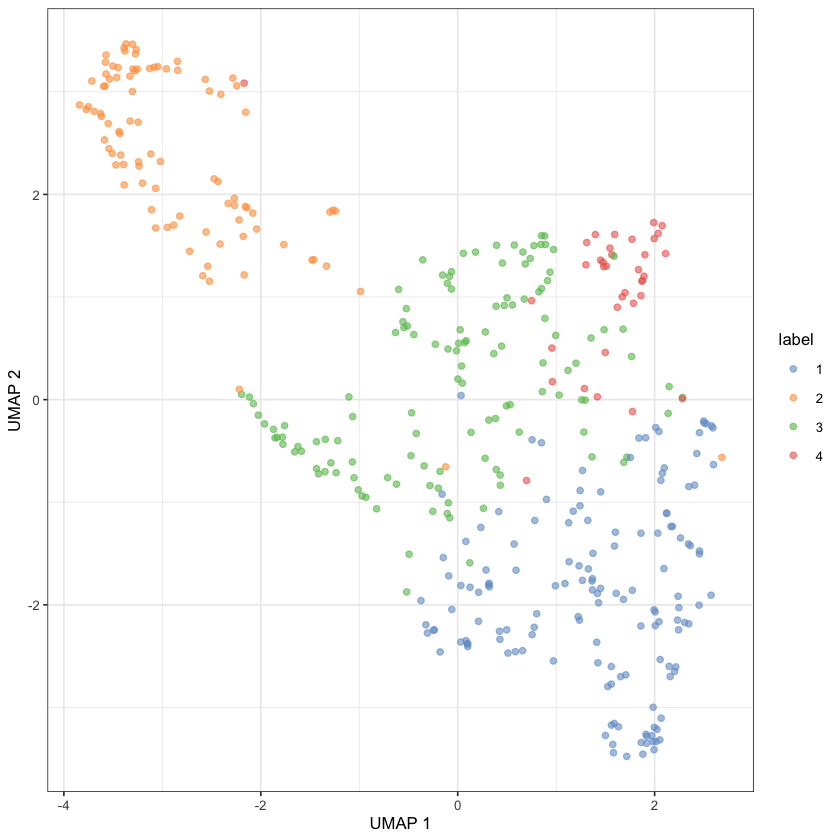

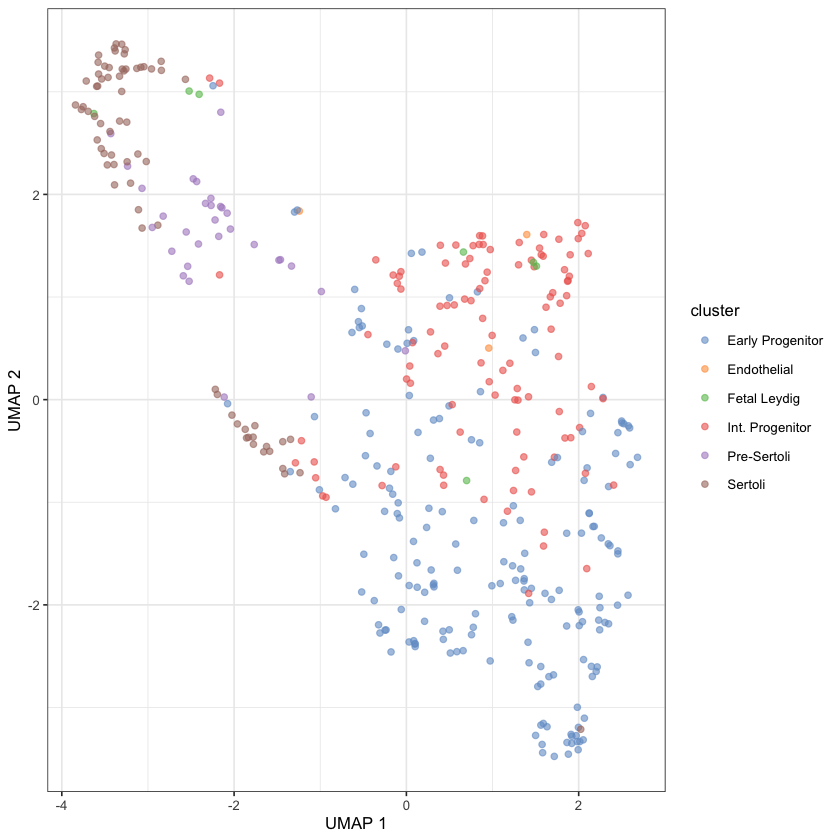

In [42]:
plotUMAP(sce_TF, colour_by="label")

plotUMAP(sce_TF, colour_by="cluster")


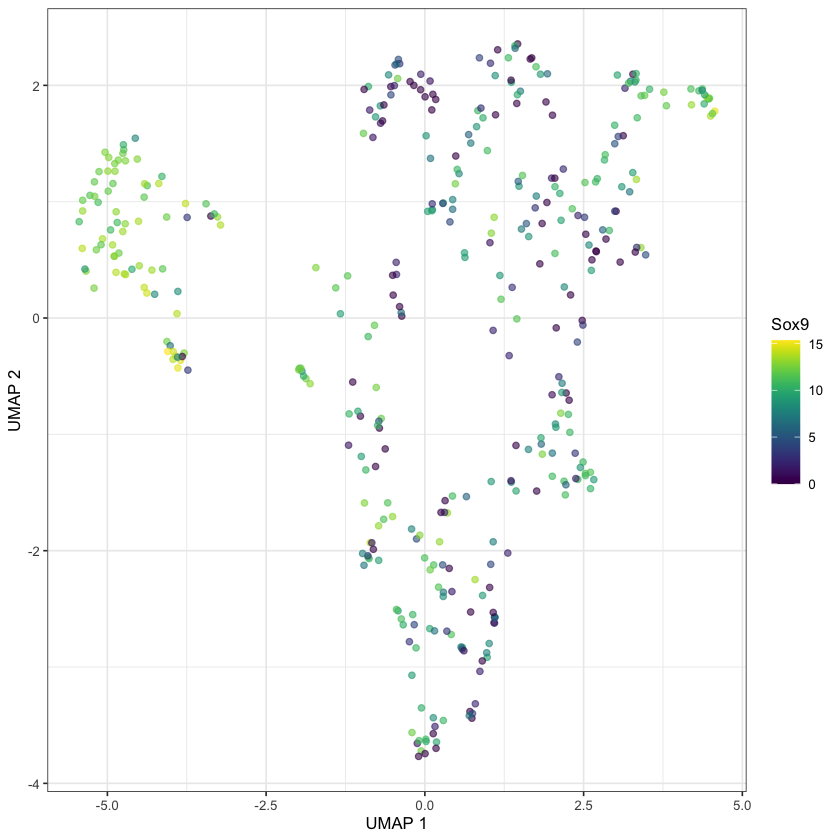

In [39]:
# Add gene expression in the UMAP plot
plotUMAP(sce_TF, colour_by="Sox9")